**Imports & Installations**

In [ ]:
import sys
import subprocess
import random
import numpy as np
import pandas as pd
from collections import defaultdict

# --- VISUALIZATION LIBRARIES ---
import matplotlib.pyplot as plt
import seaborn as sns

# Install libraries if missing
def install(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

print("Checking dependencies...")
install("optuna")
install("pytorch_tabnet")
install("xgboost")
install("lightgbm")
install("imblearn")
install("matplotlib")
install("seaborn")

from sklearn.utils.class_weight import compute_class_weight

# Core ML
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score, roc_curve, auc, confusion_matrix
)

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier

# Tree Models
import xgboost as xgb
import lightgbm as lgb

# Optimization
import optuna

Checking dependencies...


**Config**

In [ ]:
SEED = 42
def set_seeds(seed=SEED):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()

Encoder = "Label Encoder"
TRIALS = 30

**Load and Proccess Data**

In [ ]:
url = "https://raw.githubusercontent.com/mahidul5130/ChurnNet_Deep_Learning_Enhanced_Customer_Churn-Prediction_in_Telecommunication_Industry/refs/heads/main/Churn-data-UCI%20Dataset(5000).csv"
df_raw = pd.read_csv(url)

print(f"Dataset shape: {df_raw.shape}")

# 1. Define Features and Target
target_col = 'churn'
df_raw[target_col] = df_raw[target_col].astype(int)
X_raw = df_raw.drop(columns=[target_col])
# Ensure target is integer
Y = df_raw[target_col].values.astype(int)

# ---------------------------

# 2. Explicitly define categorical columns
cat_cols = ['internationalplan', 'voicemailplan']
available_cat_cols = [c for c in cat_cols if c in X_raw.columns]
print(f"Categorical Columns to Encode: {available_cat_cols}")

# 3. Apply Encoding
df_final = X_raw.copy()

if Encoder == "Label Encoder":
    le = LabelEncoder()
    for col in available_cat_cols:
        df_final[col] = le.fit_transform(df_final[col].astype(str))
        print(f"Encoded {col}: {df_final[col].unique()}")
    X = df_final.values
else:
    X = df_final.values

# 4. Helper for class weights
def get_adaptive_weights(y):
    """
    Returns weights in two formats:
    1. dict: {0: w0, 1: w1} (For Keras, TabNet)
    2. float: scale_pos_weight (For XGBoost, LightGBM, PyTorch Loss)
    """
    neg_count, pos_count = np.bincount(y)
    total = neg_count + pos_count

    # Format 1: Dictionary (Balanced)
    w0 = total / (2 * neg_count)
    w1 = total / (2 * pos_count)
    weight_dict = {0: w0, 1: w1}

    # Format 2: Scale Factor (Neg/Pos)
    scale_pos_weight = neg_count / pos_count

    return weight_dict, scale_pos_weight

# 5. Helper for threshold
def get_optimal_threshold(y_true, y_prob):
    """
    Finds the threshold that maximizes F1 score on the provided data.
    Now searches from 0.10 up to 0.90 to handle class-weighted probability shifts.
    """
    best_thresh = 0.5
    best_f1 = 0.0

    # CHANGED: Search from 0.1 up to 0.91 (inclusive of 0.90)
    for thresh in np.arange(0.1, 0.91, 0.01):
        y_pred = (y_prob >= thresh).astype(int)
        score = f1_score(y_true, y_pred)

        # Using >= to keep the highest threshold if scores are identical (optional preference)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh

    return best_thresh

Dataset shape: (5000, 18)
Categorical Columns to Encode: ['internationalplan', 'voicemailplan']
Encoded internationalplan: [0 1]
Encoded voicemailplan: [1 0]


**EDA**

--- STANDARD EDA FOR: churn ---


/tmp/ipython-input-2214233166.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[target_col], palette="viridis")


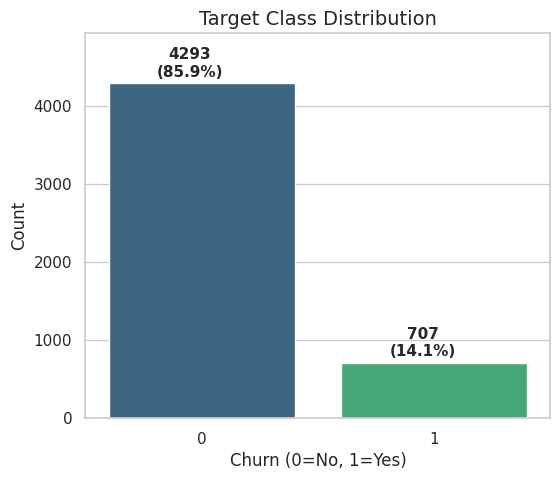

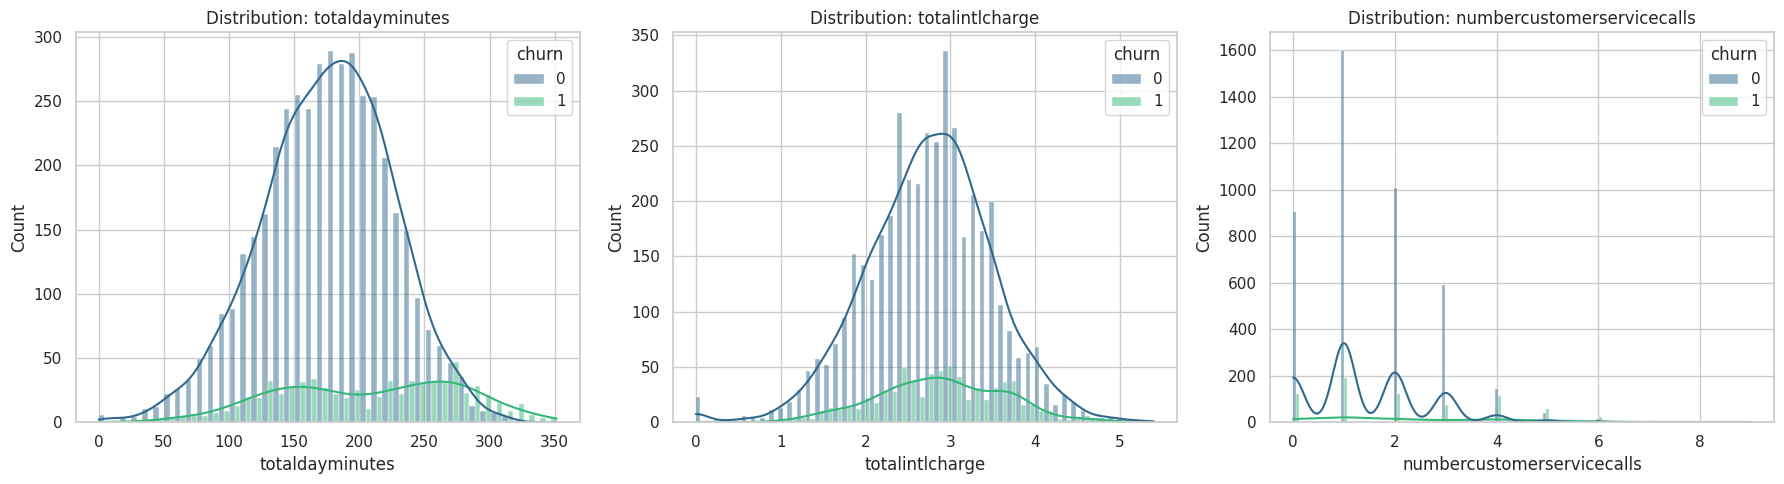

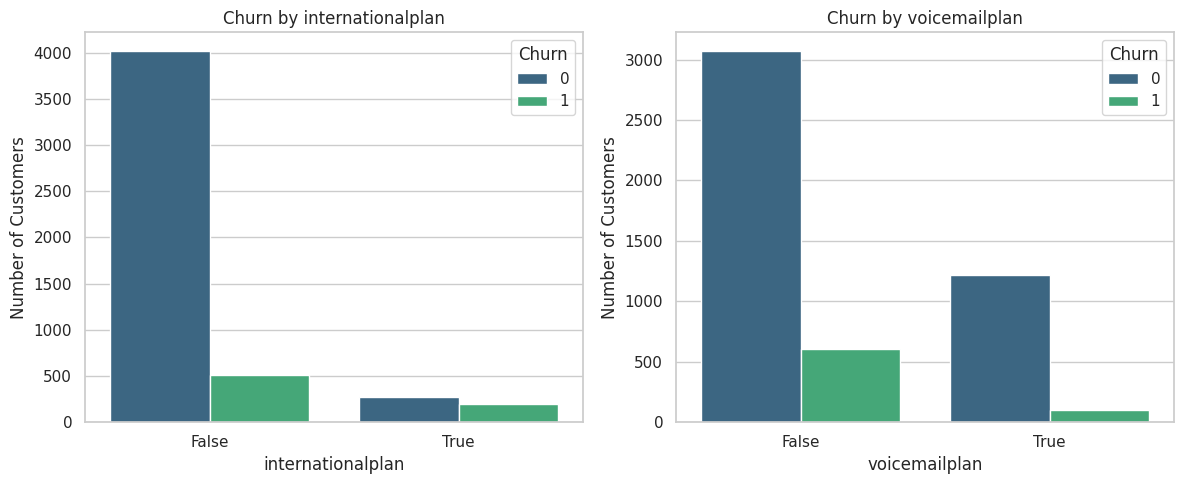

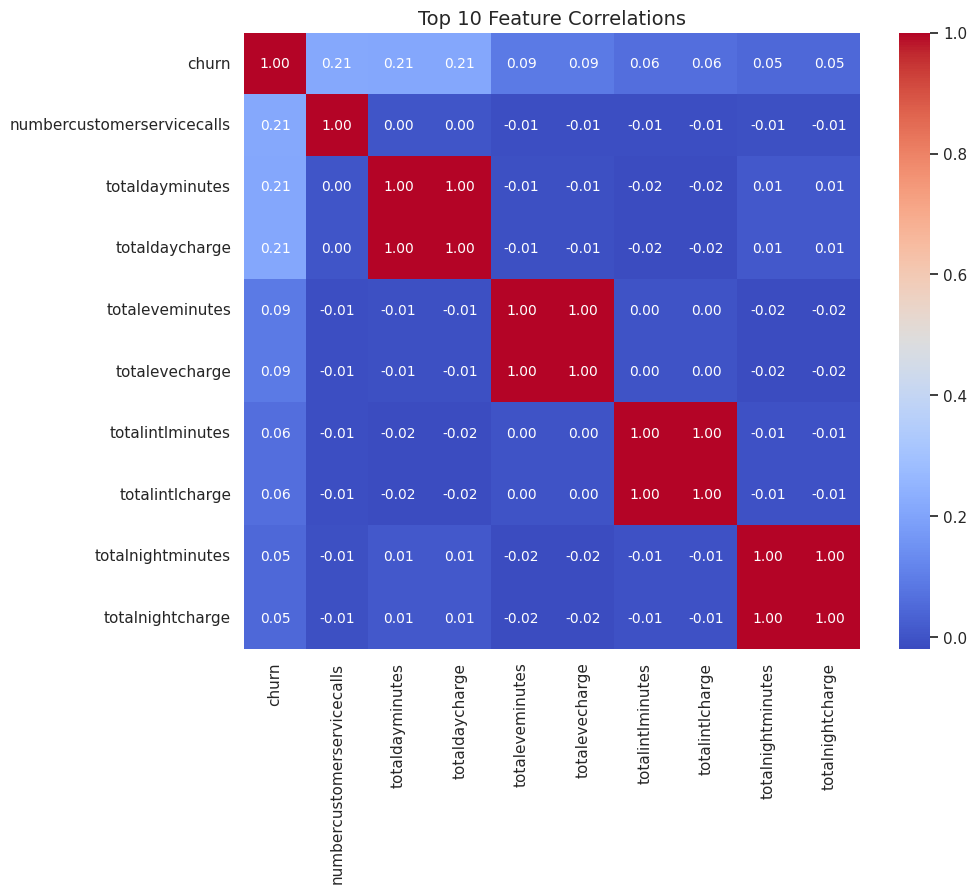

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a clean, standard visual style
sns.set_theme(style="whitegrid")

def run_standard_eda(df, target_col):
    print(f"--- STANDARD EDA FOR: {target_col} ---")

    # 1. CLASS BALANCE (Counts + Percentages)
    plt.figure(figsize=(6, 5))
    ax = sns.countplot(x=df[target_col], palette="viridis")
    plt.title("Target Class Distribution", fontsize=14)
    plt.xlabel("Churn (0=No, 1=Yes)")
    plt.ylabel("Count")

    # Calculate total to compute percentages
    total = len(df)

    # Add labels on top (Count + %)
    for p in ax.patches:
        count = int(p.get_height())
        pct = 100 * count / total
        ax.annotate(f'{count}\n({pct:.1f}%)',
                    (p.get_x() + 0.35, p.get_height() + 50),
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.ylim(0, df[target_col].value_counts().max() * 1.15) # Add headroom for text
    plt.show()

    # 2. NUMERICAL DISTRIBUTIONS (Histograms)
    num_features = ["totaldayminutes", "totalintlcharge", "numbercustomerservicecalls"]
    valid_nums = [c for c in num_features if c in df.columns]

    if valid_nums:
        fig, axes = plt.subplots(1, len(valid_nums), figsize=(18, 5))
        if len(valid_nums) == 1: axes = [axes]

        for ax, feature in zip(axes, valid_nums):
            sns.histplot(data=df, x=feature, hue=target_col, multiple="dodge",
                         kde=True, palette="viridis", ax=ax)
            ax.set_title(f"Distribution: {feature}")

        plt.tight_layout()
        plt.show()

    # 3. CATEGORICAL BREAKDOWN (Grouped Bars)
    cat_features = ["internationalplan", "voicemailplan"]
    valid_cats = [c for c in cat_features if c in df.columns]

    if valid_cats:
        fig, axes = plt.subplots(1, len(valid_cats), figsize=(12, 5))
        if len(valid_cats) == 1: axes = [axes]

        for ax, feature in zip(axes, valid_cats):
            sns.countplot(data=df, x=feature, hue=target_col, palette="viridis", ax=ax)
            ax.set_title(f"Churn by {feature}")
            ax.set_ylabel("Number of Customers")
            ax.legend(title="Churn", loc='upper right')

        plt.tight_layout()
        plt.show()

    # 4. CORRELATION MATRIX
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.shape[1] > 1:
        corr = numeric_df.corr()
        if target_col in corr.columns:
            cols = corr.nlargest(10, target_col)[target_col].index
            cm = np.corrcoef(df[cols].values.T)

            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                        annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,
                        cmap="coolwarm")
            plt.title("Top 10 Feature Correlations", fontsize=14)
            plt.show()

# --- EXECUTE ---
df_raw['churn'] = df_raw['churn'].astype(int)
run_standard_eda(df_raw, "churn")

In [ ]:
# ============================================
# FEATURE SELECTION: REMOVE REDUNDANT DATA
# ============================================

# 1. Identify columns to drop
# We drop 'charge' columns because they are 100% correlated with 'minutes'
cols_to_drop = [
    'totaldaycharge',
    'totalevecharge',
    'totalnightcharge',
    'totalintlcharge'
]

print(f"Dropping redundant features: {cols_to_drop}")

# 2. Remove them from the dataframe
df_final = df_raw.drop(columns=cols_to_drop)

# 3. Verify the drop
print(f"New shape: {df_final.shape}")

# RE-DEFINE X AND Y
target_col = 'churn'

# Define X (features) and Y (target) based on the NEW dataframe
X_raw = df_final.drop(columns=[target_col])
Y = df_final[target_col].values.astype(int)

# Re-identify categorical columns (they might still exist)
cat_cols = ['internationalplan', 'voicemailplan']
available_cat_cols = [c for c in cat_cols if c in X_raw.columns]

# Re-Encode
if Encoder == "Label Encoder":
    le = LabelEncoder()
    # Apply encoding to the remaining data
    for col in available_cat_cols:
        X_raw[col] = le.fit_transform(X_raw[col].astype(str))

    X = X_raw.values
else:
    X = X_raw.values

print("Feature selection complete. Redundant columns removed.")

Dropping redundant features: ['totaldaycharge', 'totalevecharge', 'totalnightcharge', 'totalintlcharge']
New shape: (5000, 14)
Feature selection complete. Redundant columns removed.


**Model Definitions**

In [ ]:
# --- A. MLP-Attention (Keras) ---
def feature_attention(inputs, reduction_ratio=4):
    hidden_units = max(1, inputs.shape[-1] // reduction_ratio)
    x = layers.Dense(hidden_units, activation='relu')(inputs)
    x = layers.Dense(inputs.shape[-1], activation='sigmoid')(x)
    return layers.Multiply()([inputs, x])

def build_mlp_att(hp, input_dim):
    hidden_units = hp['hidden_units']
    dropout_rate = hp['dropout_rate']
    lr = hp['learning_rate']
    l2_reg = hp['l2_regularization']

    inputs = layers.Input(shape=(input_dim,))
    x = feature_attention(inputs)

    for units in [hidden_units, hidden_units // 2]:
        x = layers.Dense(units, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model

# --- B. FT-Transformer (PyTorch) ---
class FTTransformerPyTorch(nn.Module):
    def __init__(self, input_dim, d_token=128, n_layers=3, n_heads=8, dropout=0.1):
        super(FTTransformerPyTorch, self).__init__()
        self.feature_embeddings = nn.ModuleList([nn.Linear(1, d_token) for _ in range(input_dim)])
        self.layer_norm_input = nn.LayerNorm(d_token)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_token))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token, nhead=n_heads, dim_feedforward=d_token * 4,
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.classifier = nn.Sequential(
            nn.Linear(d_token, 64), nn.ReLU(), nn.Dropout(dropout), nn.Linear(64, 1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        tokens = [emb(x[:, i].unsqueeze(-1)) for i, emb in enumerate(self.feature_embeddings)]
        x_tokens = torch.stack(tokens, dim=1)
        x_tokens = self.layer_norm_input(x_tokens)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x_tokens = torch.cat([cls_tokens, x_tokens], dim=1)
        x_encoded = self.transformer(x_tokens)
        return self.classifier(x_encoded[:, 0, :])

def train_pytorch_model(model, train_loader, val_loader, epochs, lr, device, pos_weight_val=1.0):
    model = model.to(device)

    # NEW: Apply Class Weight to Loss Function
    pos_weight_tensor = torch.tensor([pos_weight_val]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_auc = 0
    patience, counter = 10, 0
    best_state = None

    for epoch in range(epochs):
        model.train()
        for X_b, y_b in train_loader:
            X_b, y_b = X_b.to(device), y_b.to(device).float()
            optimizer.zero_grad()
            loss = criterion(model(X_b).squeeze(), y_b)
            loss.backward()
            optimizer.step()

        # ... (Rest of validation logic remains the same) ...
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
             for X_b, y_b in val_loader:
                X_b = X_b.to(device)
                out = model(X_b).squeeze()
                val_preds.extend(torch.sigmoid(out).cpu().numpy())
                val_targets.extend(y_b.numpy())

        auc_score = roc_auc_score(val_targets, val_preds)
        if auc_score > best_auc:
            best_auc = auc_score
            best_state = model.state_dict().copy()
            counter = 0
        else:
            counter += 1
            if counter >= patience: break

    if best_state: model.load_state_dict(best_state)
    return model, best_auc

def predict_pytorch(model, X, device):
    model.eval()
    X_t = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        out = model(X_t).squeeze()
        probs = torch.sigmoid(out).cpu().numpy()
    return probs

**Unified Optuna Tuning**

In [ ]:
def tune_hyperparameters(X, Y, model_type):
    print(f"\nTUNING HYPERPARAMETERS FOR: {model_type}")

    X_tune, X_val, Y_tune, Y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=SEED)
    scaler = StandardScaler()
    X_tune = scaler.fit_transform(X_tune)
    X_val = scaler.transform(X_val)

    # CALCULATE WEIGHTS
    weight_dict, scale_pos_weight = get_adaptive_weights(Y_tune)

    def objective(trial):
        if model_type == "MLP-Attention":
            tf.keras.backend.clear_session()
            params = {
                'hidden_units': trial.suggest_categorical('hidden_units', [128, 256]),
                'dropout_rate': trial.suggest_float('dropout_rate', 0.2, 0.5),
                'learning_rate': trial.suggest_categorical('learning_rate', [1e-3, 5e-4]),
                'l2_regularization': trial.suggest_float('l2_regularization', 1e-5, 1e-3, log=True)
            }
            model = build_mlp_att(params, X_tune.shape[1])
            early = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')

            # class_weight
            hist = model.fit(X_tune, Y_tune, validation_data=(X_val, Y_val),
                             epochs=20, batch_size=64, callbacks=[early], verbose=0,
                             class_weight=weight_dict) # <--- NEW
            return max(hist.history['val_AUC'])

        elif model_type == "FT-Transformer":
            d_token = trial.suggest_categorical('d_token', [64, 128])
            n_layers = trial.suggest_int('n_layers', 2, 3)
            dropout = trial.suggest_float('dropout', 0.1, 0.3)
            lr = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
            batch_size = trial.suggest_categorical('batch_size', [64, 128])

            model = FTTransformerPyTorch(X_tune.shape[1], d_token=d_token, n_layers=n_layers, dropout=dropout)

            train_ds = TensorDataset(torch.FloatTensor(X_tune), torch.LongTensor(Y_tune))
            val_ds = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(Y_val))
            train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_ds, batch_size=batch_size)

            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

            # pos_weight_val
            _, best_auc = train_pytorch_model(model, train_loader, val_loader, 20, lr, device,
                                              pos_weight_val=scale_pos_weight) # <--- NEW
            return best_auc

        elif model_type == "TabNet":
            # TabNet handles weights internally via fit(weights=...)
            params = {
                'n_d': trial.suggest_int('n_d', 16, 64, step=16),
                'n_a': trial.suggest_int('n_a', 16, 64, step=16),
                'gamma': trial.suggest_float('gamma', 1.0, 1.5),
                'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-4, 1e-2, log=True),
                'lr': trial.suggest_categorical('learning_rate', [0.02, 0.01])
            }
            clf = TabNetClassifier(n_d=params['n_d'], n_a=params['n_a'], gamma=params['gamma'],
                                   lambda_sparse=params['lambda_sparse'],
                                   optimizer_params=dict(lr=params['lr']), verbose=0)

            clf.fit(X_tune, Y_tune, eval_set=[(X_val, Y_val)],
                    max_epochs=20, patience=5, batch_size=256, eval_metric=['auc'],
                    weights=weight_dict)

            val_auc_key = next(k for k in clf.history.history.keys() if "val" in k and "auc" in k)
            return max(clf.history[val_auc_key])

        elif model_type == "XGBoost":
            params = {
                'max_depth': trial.suggest_int('max_depth', 3, 8),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
                'n_estimators': trial.suggest_int('n_estimators', 100, 300),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'scale_pos_weight': scale_pos_weight,
                'eval_metric': 'auc', 'objective': 'binary:logistic', 'use_label_encoder': False
            }
            model = xgb.XGBClassifier(**params)
            model.fit(X_tune, Y_tune, eval_set=[(X_val, Y_val)], verbose=False)
            return roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])

        elif model_type == "LightGBM":
            params = {
                'num_leaves': trial.suggest_int('num_leaves', 20, 100),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
                'n_estimators': trial.suggest_int('n_estimators', 100, 300),
                'scale_pos_weight': scale_pos_weight,
                'metric': 'auc', 'objective': 'binary', 'verbose': -1
            }
            model = lgb.LGBMClassifier(**params)
            model.fit(X_tune, Y_tune, eval_set=[(X_val, Y_val)], callbacks=[lgb.early_stopping(10, verbose=False)])
            return roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=TRIALS)
    return study.best_params

**K-Fold Cross-Validation Evaluation**

In [ ]:
def kfold_evaluation(X, Y, best_params, model_type):
    print(f"\nRUNNING K-FOLD CV FOR: {model_type}")

    metrics = defaultdict(list)
    fold_thresholds = [] # <--- NEW: List to track the best threshold for each fold
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Store all predictions for Global ROC
    all_y_true = []
    all_y_prob = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, Y), 1):
        print(f"Fold {fold}/10...", end=" ")

        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]

        # Scale
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # CALCULATE WEIGHTS
        weight_dict, scale_pos_weight = get_adaptive_weights(Y_train)

        # --- IMPORTANT: Create Validation Split for Threshold Tuning ---
        X_tr, X_val, Y_tr, Y_val = train_test_split(
            X_train, Y_train, test_size=0.1, stratify=Y_train, random_state=SEED
        )

        # Initialize threshold vars
        best_thresh = 0.5

        # --- TRAIN MODELS ---
        if model_type == "MLP-Attention":
            model = build_mlp_att(best_params, X_tr.shape[1])
            early = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')

            # 1. Fit on sub-train (X_tr), validate on X_val
            model.fit(X_tr, Y_tr, validation_data=(X_val, Y_val), epochs=100, batch_size=32,
                      callbacks=[early], verbose=0, class_weight=weight_dict)

            # 2. Find best threshold using Validation Data
            Y_val_prob = model.predict(X_val, verbose=0).flatten()
            best_thresh = get_optimal_threshold(Y_val, Y_val_prob)

            # 3. Predict on Test
            Y_prob = model.predict(X_test, verbose=0).flatten()

        elif model_type == "FT-Transformer":
            # Prepare PyTorch Datasets
            model = FTTransformerPyTorch(X_tr.shape[1],
                                         d_token=best_params['d_token'],
                                         n_layers=best_params['n_layers'],
                                         dropout=best_params['dropout'])

            train_ds = TensorDataset(torch.FloatTensor(X_tr), torch.LongTensor(Y_tr))
            val_ds = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(Y_val))

            train_loader = DataLoader(train_ds, batch_size=best_params['batch_size'], shuffle=True)
            val_loader = DataLoader(val_ds, batch_size=best_params['batch_size'])

            # 1. Train
            model, _ = train_pytorch_model(model, train_loader, val_loader, 100,
                                           best_params['learning_rate'], device,
                                           pos_weight_val=scale_pos_weight)

            # 2. Find best threshold using Validation Data
            Y_val_prob = predict_pytorch(model, X_val, device)
            best_thresh = get_optimal_threshold(Y_val, Y_val_prob)

            # 3. Predict on Test
            Y_prob = predict_pytorch(model, X_test, device)

        elif model_type == "TabNet":
            clf = TabNetClassifier(n_d=best_params['n_d'], n_a=best_params['n_a'],
                                   gamma=best_params['gamma'], lambda_sparse=best_params['lambda_sparse'],
                                   optimizer_params=dict(lr=best_params['learning_rate']), verbose=0)

            # 1. Train
            clf.fit(X_tr, Y_tr, eval_set=[(X_val, Y_val)], max_epochs=100, patience=10,
                    batch_size=256, weights=weight_dict)

            # 2. Find best threshold using Validation Data
            Y_val_prob = clf.predict_proba(X_val)[:, 1]
            best_thresh = get_optimal_threshold(Y_val, Y_val_prob)

            # 3. Predict on Test
            Y_prob = clf.predict_proba(X_test)[:, 1]

        elif model_type == "XGBoost":
            p = best_params.copy()
            p.update({
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'use_label_encoder': False,
                'scale_pos_weight': scale_pos_weight
            })

            model = xgb.XGBClassifier(**p)

            # STEP 1: Train on 90% to find the best threshold
            model.fit(X_tr, Y_tr, verbose=False)
            Y_val_prob = model.predict_proba(X_val)[:, 1]
            best_thresh = get_optimal_threshold(Y_val, Y_val_prob)

            # STEP 2: Re-train on FULL (100%) data using that threshold logic
            model.fit(X_train, Y_train, verbose=False)

            # Predict on Test
            Y_prob = model.predict_proba(X_test)[:, 1]


        elif model_type == "LightGBM":
            p = best_params.copy()
            p.update({'objective': 'binary', 'metric': 'auc', 'verbose': -1,
                      'scale_pos_weight': scale_pos_weight})

            # STEP 1: Train on 90% with Early Stopping
            model = lgb.LGBMClassifier(**p)
            callbacks = [lgb.early_stopping(stopping_rounds=10, verbose=False)]
            model.fit(X_tr, Y_tr, eval_set=[(X_val, Y_val)], eval_metric='auc', callbacks=callbacks)

            # Safety check for best iteration
            best_iter = getattr(model, 'best_iteration_', None)
            if best_iter is None or best_iter <= 0:
                best_iter = int(p.get('n_estimators', 100))

            # Find Best Threshold
            Y_val_prob = model.predict_proba(X_val)[:, 1]
            best_thresh = get_optimal_threshold(Y_val, Y_val_prob)

            # STEP 2: Retrain on FULL (100%) data
            p['n_estimators'] = best_iter
            final_model = lgb.LGBMClassifier(**p)
            final_model.fit(X_train, Y_train)

            # Predict on Test
            Y_prob = final_model.predict_proba(X_test)[:, 1]

        # --- SAVE THRESHOLD FOR THIS FOLD ---
        fold_thresholds.append(best_thresh) # <--- NEW
        # ------------------------------------

        # --- APPLY OPTIMIZED THRESHOLD ---
        Y_pred = (Y_prob >= best_thresh).astype(int)

        # Aggregate Metrics
        metrics['accuracy'].append(accuracy_score(Y_test, Y_pred))
        metrics['f1'].append(f1_score(Y_test, Y_pred))
        metrics['auc'].append(roc_auc_score(Y_test, Y_prob))
        metrics['precision'].append(precision_score(Y_test, Y_pred, zero_division=0))
        metrics['recall'].append(recall_score(Y_test, Y_pred, zero_division=0))
        metrics['mcc'].append(matthews_corrcoef(Y_test, Y_pred))

        # Collect for ROC Plot
        all_y_true.extend(Y_test)
        all_y_prob.extend(Y_prob)

        print(f"Thresh: {best_thresh:.2f} | Acc: {metrics['accuracy'][-1]:.4f} | F1: {metrics['f1'][-1]:.4f} | AUC: {metrics['auc'][-1]:.4f}")

    print(f"\nAverage F1 across all folds: {np.mean(metrics['f1']):.4f}")

    # Calculate Average Threshold
    avg_thresh = np.mean(fold_thresholds) # <--- NEW

    # Return metrics, predictions AND the average threshold
    avg_metrics = {k: np.mean(v) for k, v in metrics.items()}
    return avg_metrics, metrics, np.array(all_y_true), np.array(all_y_prob), avg_thresh

**Main**

In [ ]:
if __name__ == "__main__":

    # --- CONFIGURATION SWITCH ---
    RUN_MODE = "All"  # "Single" or "All"
    MODEL_TYPE = "LightGBM"
    ALL_MODELS = ["MLP-Attention", "FT-Transformer", "TabNet", "XGBoost", "LightGBM"]
    # ----------------------------

    results_summary = {}
    roc_data = {}
    raw_metrics_storage = {}
    final_thresholds = {} # <--- NEW: Dictionary to store thresholds

    models_to_run = [MODEL_TYPE] if RUN_MODE == "Single" else ALL_MODELS

    if RUN_MODE == "All":
        print(f"\nSTARTING BENCHMARK ON ALL MODELS: {models_to_run}")

    for current_model in models_to_run:
        print("\n" + "#"*60)
        print(f"PIPELINE: {current_model}")
        print("#"*60)

        try:
            # 1. Tune
            best_params = tune_hyperparameters(X, Y, current_model)
            print(f"Best Params: {best_params}")

            # 2. Evaluate
            # --- UPDATED: Unpack the new 5th return value (avg_thresh) ---
            final_metrics, raw_metrics, y_true, y_prob, avg_thresh = kfold_evaluation(X, Y, best_params, current_model)

            results_summary[current_model] = final_metrics
            roc_data[current_model] = (y_true, y_prob)
            raw_metrics_storage[current_model] = raw_metrics['f1']

            # Save the threshold!
            final_thresholds[current_model] = avg_thresh
            print(f"Global Best Threshold (Avg): {avg_thresh:.4f}")

        except Exception as e:
            print(f"FAILED: {current_model} crashed with error: {e}")
            import traceback
            traceback.print_exc()

[I 2026-01-17 11:51:59,865] A new study created in memory with name: no-name-dde1eab2-2de9-406c-8da6-dc982e068b0b



STARTING BENCHMARK ON ALL MODELS: ['MLP-Attention', 'FT-Transformer', 'TabNet', 'XGBoost', 'LightGBM']

############################################################
PIPELINE: MLP-Attention
############################################################

TUNING HYPERPARAMETERS FOR: MLP-Attention


[I 2026-01-17 11:52:15,338] Trial 0 finished with value: 0.9106664061546326 and parameters: {'hidden_units': 256, 'dropout_rate': 0.4012747652426679, 'learning_rate': 0.001, 'l2_regularization': 0.0004608122510716591}. Best is trial 0 with value: 0.9106664061546326.
[I 2026-01-17 11:52:35,451] Trial 1 finished with value: 0.9195749163627625 and parameters: {'hidden_units': 256, 'dropout_rate': 0.23456457350388785, 'learning_rate': 0.001, 'l2_regularization': 0.0007120669823691989}. Best is trial 1 with value: 0.9195749163627625.
[I 2026-01-17 11:52:49,724] Trial 2 finished with value: 0.9144189357757568 and parameters: {'hidden_units': 256, 'dropout_rate': 0.20020147228661372, 'learning_rate': 0.001, 'l2_regularization': 0.0007847408144048346}. Best is trial 1 with value: 0.9195749163627625.
[I 2026-01-17 11:53:02,346] Trial 3 finished with value: 0.9026123285293579 and parameters: {'hidden_units': 128, 'dropout_rate': 0.2140511904353441, 'learning_rate': 0.0005, 'l2_regularization': 4

Best Params: {'hidden_units': 128, 'dropout_rate': 0.26626385834615107, 'learning_rate': 0.001, 'l2_regularization': 0.0006480372180006068}

RUNNING K-FOLD CV FOR: MLP-Attention
Fold 1/10... Thresh: 0.77 | Acc: 0.9340 | F1: 0.7519 | AUC: 0.9115
Fold 2/10... Thresh: 0.70 | Acc: 0.9460 | F1: 0.8085 | AUC: 0.9245
Fold 3/10... Thresh: 0.83 | Acc: 0.9400 | F1: 0.7619 | AUC: 0.9387
Fold 4/10... Thresh: 0.72 | Acc: 0.9340 | F1: 0.7591 | AUC: 0.9225
Fold 5/10... Thresh: 0.83 | Acc: 0.9420 | F1: 0.7852 | AUC: 0.9460
Fold 6/10... Thresh: 0.58 | Acc: 0.9180 | F1: 0.7453 | AUC: 0.9221
Fold 7/10... Thresh: 0.85 | Acc: 0.9620 | F1: 0.8550 | AUC: 0.9288
Fold 8/10... Thresh: 0.80 | Acc: 0.9440 | F1: 0.7879 | AUC: 0.9078
Fold 9/10... Thresh: 0.50 | Acc: 0.9200 | F1: 0.7436 | AUC: 0.9269
Fold 10/10... 

[I 2026-01-17 12:05:18,418] A new study created in memory with name: no-name-53150914-1e34-42f6-af87-770e8ef7f452


Thresh: 0.87 | Acc: 0.9480 | F1: 0.7903 | AUC: 0.9101

Average F1 across all folds: 0.7789
Global Best Threshold (Avg): 0.7450

############################################################
PIPELINE: FT-Transformer
############################################################

TUNING HYPERPARAMETERS FOR: FT-Transformer


[I 2026-01-17 12:05:39,082] Trial 0 finished with value: 0.932215424499872 and parameters: {'d_token': 128, 'n_layers': 3, 'dropout': 0.2507031594218411, 'learning_rate': 0.000902994020177982, 'batch_size': 64}. Best is trial 0 with value: 0.932215424499872.
[I 2026-01-17 12:05:45,487] Trial 1 finished with value: 0.9340070509168669 and parameters: {'d_token': 64, 'n_layers': 2, 'dropout': 0.19305064758868218, 'learning_rate': 0.0006647394272008686, 'batch_size': 128}. Best is trial 1 with value: 0.9340070509168669.
[I 2026-01-17 12:05:52,144] Trial 2 finished with value: 0.9251562512900535 and parameters: {'d_token': 64, 'n_layers': 2, 'dropout': 0.1283931594936947, 'learning_rate': 0.00036810317290669823, 'batch_size': 128}. Best is trial 1 with value: 0.9340070509168669.
[I 2026-01-17 12:05:58,334] Trial 3 finished with value: 0.92123448839571 and parameters: {'d_token': 128, 'n_layers': 2, 'dropout': 0.2718743835914532, 'learning_rate': 0.00016834221327862264, 'batch_size': 128}. B

Best Params: {'d_token': 128, 'n_layers': 3, 'dropout': 0.16757936696531858, 'learning_rate': 0.0005160997915944549, 'batch_size': 64}

RUNNING K-FOLD CV FOR: FT-Transformer
Fold 1/10... Thresh: 0.86 | Acc: 0.9620 | F1: 0.8593 | AUC: 0.9269
Fold 2/10... Thresh: 0.87 | Acc: 0.9660 | F1: 0.8741 | AUC: 0.9274
Fold 3/10... Thresh: 0.79 | Acc: 0.9580 | F1: 0.8467 | AUC: 0.9315
Fold 4/10... Thresh: 0.50 | Acc: 0.9640 | F1: 0.8714 | AUC: 0.9378
Fold 5/10... Thresh: 0.78 | Acc: 0.9660 | F1: 0.8811 | AUC: 0.9454
Fold 6/10... Thresh: 0.62 | Acc: 0.9560 | F1: 0.8406 | AUC: 0.8969
Fold 7/10... Thresh: 0.86 | Acc: 0.9740 | F1: 0.9023 | AUC: 0.8990
Fold 8/10... Thresh: 0.59 | Acc: 0.9400 | F1: 0.7857 | AUC: 0.8871
Fold 9/10... Thresh: 0.63 | Acc: 0.9660 | F1: 0.8722 | AUC: 0.9190
Fold 10/10... 

[I 2026-01-17 12:15:13,846] A new study created in memory with name: no-name-fe1919fb-8784-4276-a714-c1e3f5cb0625


Thresh: 0.71 | Acc: 0.9620 | F1: 0.8571 | AUC: 0.8994

Average F1 across all folds: 0.8590
Global Best Threshold (Avg): 0.7210

############################################################
PIPELINE: TabNet
############################################################

TUNING HYPERPARAMETERS FOR: TabNet


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:15:19,981] Trial 0 finished with value: 0.9117851039060759 and parameters: {'n_d': 48, 'n_a': 48, 'gamma': 1.1450195512856605, 'lambda_sparse': 0.0030174085776914217, 'learning_rate': 0.02}. Best is trial 0 with value: 0.9117851039060759.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_auc = 0.91179


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:15:25,160] Trial 1 finished with value: 0.9125612001420091 and parameters: {'n_d': 48, 'n_a': 48, 'gamma': 1.4589173365801338, 'lambda_sparse': 0.0002159661304932959, 'learning_rate': 0.01}. Best is trial 1 with value: 0.9125612001420091.



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_auc = 0.91256


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:15:31,702] Trial 2 finished with value: 0.9277982810294009 and parameters: {'n_d': 16, 'n_a': 48, 'gamma': 1.0038260624075008, 'lambda_sparse': 0.0006878686119183321, 'learning_rate': 0.02}. Best is trial 2 with value: 0.9277982810294009.



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_0_auc = 0.9278


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:15:39,560] Trial 3 finished with value: 0.9221426861186106 and parameters: {'n_d': 16, 'n_a': 64, 'gamma': 1.0595493089001375, 'lambda_sparse': 0.00014668008449368952, 'learning_rate': 0.02}. Best is trial 2 with value: 0.9277982810294009.



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_0_auc = 0.92214


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:15:44,611] Trial 4 finished with value: 0.8945087063136254 and parameters: {'n_d': 32, 'n_a': 16, 'gamma': 1.1265797652956178, 'lambda_sparse': 0.0028364606052249087, 'learning_rate': 0.01}. Best is trial 2 with value: 0.9277982810294009.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_auc = 0.89451


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:15:48,295] Trial 5 finished with value: 0.8819838340805324 and parameters: {'n_d': 16, 'n_a': 48, 'gamma': 1.1034437225583509, 'lambda_sparse': 0.0010750441885932559, 'learning_rate': 0.02}. Best is trial 2 with value: 0.9277982810294009.



Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_auc = 0.88198


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:15:53,673] Trial 6 finished with value: 0.9101792452051287 and parameters: {'n_d': 16, 'n_a': 32, 'gamma': 1.3734724983937392, 'lambda_sparse': 0.0047265032382480966, 'learning_rate': 0.02}. Best is trial 2 with value: 0.9277982810294009.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_auc = 0.91018


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:16:00,754] Trial 7 finished with value: 0.9062574823107852 and parameters: {'n_d': 48, 'n_a': 16, 'gamma': 1.1889047496646878, 'lambda_sparse': 0.00012296889549826692, 'learning_rate': 0.01}. Best is trial 2 with value: 0.9277982810294009.



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_0_auc = 0.90626


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:16:08,453] Trial 8 finished with value: 0.9198226537537463 and parameters: {'n_d': 48, 'n_a': 16, 'gamma': 1.2351066906389239, 'lambda_sparse': 0.0004521731047012147, 'learning_rate': 0.02}. Best is trial 2 with value: 0.9277982810294009.



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_0_auc = 0.91982


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:16:14,037] Trial 9 finished with value: 0.8843534045030096 and parameters: {'n_d': 32, 'n_a': 16, 'gamma': 1.1846837118803266, 'lambda_sparse': 0.000212749411940396, 'learning_rate': 0.01}. Best is trial 2 with value: 0.9277982810294009.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_auc = 0.88435
Stop training because you reached max_epochs = 20 with best_epoch = 16 and best_val_0_auc = 0.90646


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:16:21,815] Trial 10 finished with value: 0.9064638908841717 and parameters: {'n_d': 64, 'n_a': 64, 'gamma': 1.029463432078222, 'lambda_sparse': 0.0008130316650894103, 'learning_rate': 0.02}. Best is trial 2 with value: 0.9277982810294009.
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:16:27,321] Trial 11 finished with value: 0.9052832338444009 and parameters: {'n_d': 16, 'n_a': 64, 'gamma': 1.028426161274781, 'lambda_sparse': 0.0005403235948858153, 'learning_rate': 0.02}. Best is trial 2 with value: 0.9277982810294009.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_auc = 0.90528


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:16:35,677] Trial 12 finished with value: 0.9258250150678258 and parameters: {'n_d': 16, 'n_a': 64, 'gamma': 1.012862917760058, 'lambda_sparse': 0.00010030752984611326, 'learning_rate': 0.02}. Best is trial 2 with value: 0.9277982810294009.


Stop training because you reached max_epochs = 20 with best_epoch = 16 and best_val_0_auc = 0.92583


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:16:43,426] Trial 13 finished with value: 0.9138863431831504 and parameters: {'n_d': 32, 'n_a': 32, 'gamma': 1.3122120502684667, 'lambda_sparse': 0.0017774111060098142, 'learning_rate': 0.02}. Best is trial 2 with value: 0.9277982810294009.


Stop training because you reached max_epochs = 20 with best_epoch = 16 and best_val_0_auc = 0.91389


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:16:51,633] Trial 14 finished with value: 0.9166357053806587 and parameters: {'n_d': 16, 'n_a': 64, 'gamma': 1.0071485322058624, 'lambda_sparse': 0.00953879370422843, 'learning_rate': 0.02}. Best is trial 2 with value: 0.9277982810294009.


Stop training because you reached max_epochs = 20 with best_epoch = 19 and best_val_0_auc = 0.91664


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:16:59,877] Trial 15 finished with value: 0.9351464262419605 and parameters: {'n_d': 32, 'n_a': 48, 'gamma': 1.0832119092961912, 'lambda_sparse': 0.0003340041302964618, 'learning_rate': 0.02}. Best is trial 15 with value: 0.9351464262419605.


Stop training because you reached max_epochs = 20 with best_epoch = 19 and best_val_0_auc = 0.93515


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:17:07,232] Trial 16 finished with value: 0.9243471296823784 and parameters: {'n_d': 32, 'n_a': 32, 'gamma': 1.0974004013352965, 'lambda_sparse': 0.0003693134095313371, 'learning_rate': 0.02}. Best is trial 15 with value: 0.9351464262419605.



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_0_auc = 0.92435


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:17:15,436] Trial 17 finished with value: 0.9064391218553655 and parameters: {'n_d': 32, 'n_a': 48, 'gamma': 1.2805820602782414, 'lambda_sparse': 0.0009329871252613107, 'learning_rate': 0.02}. Best is trial 15 with value: 0.9351464262419605.


Stop training because you reached max_epochs = 20 with best_epoch = 18 and best_val_0_auc = 0.90644

Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_0_auc = 0.90747


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:17:22,929] Trial 18 finished with value: 0.9074711647222979 and parameters: {'n_d': 64, 'n_a': 48, 'gamma': 1.081746055812573, 'lambda_sparse': 0.00024456373514558134, 'learning_rate': 0.01}. Best is trial 15 with value: 0.9351464262419605.
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:17:30,629] Trial 19 finished with value: 0.924124208423121 and parameters: {'n_d': 32, 'n_a': 32, 'gamma': 1.1664188447368744, 'lambda_sparse': 0.0006196793716461196, 'learning_rate': 0.02}. Best is trial 15 with value: 0.9351464262419605.


Stop training because you reached max_epochs = 20 with best_epoch = 19 and best_val_0_auc = 0.92412


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:17:36,250] Trial 20 finished with value: 0.88786235025058 and parameters: {'n_d': 16, 'n_a': 48, 'gamma': 1.2347008126151926, 'lambda_sparse': 0.0014511894584827323, 'learning_rate': 0.02}. Best is trial 15 with value: 0.9351464262419605.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_auc = 0.88786


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:17:39,821] Trial 21 finished with value: 0.8961599749007173 and parameters: {'n_d': 16, 'n_a': 64, 'gamma': 1.0083828795765488, 'lambda_sparse': 0.000325338224615327, 'learning_rate': 0.02}. Best is trial 15 with value: 0.9351464262419605.



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_auc = 0.89616


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:17:48,061] Trial 22 finished with value: 0.9183695373971053 and parameters: {'n_d': 16, 'n_a': 64, 'gamma': 1.0590897003987834, 'lambda_sparse': 0.00010296416753922976, 'learning_rate': 0.02}. Best is trial 15 with value: 0.9351464262419605.



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_0_auc = 0.91837


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:17:53,543] Trial 23 finished with value: 0.895540749180558 and parameters: {'n_d': 32, 'n_a': 48, 'gamma': 1.0586138906030476, 'lambda_sparse': 0.00016610789002794636, 'learning_rate': 0.02}. Best is trial 15 with value: 0.9351464262419605.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_auc = 0.89554


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:18:01,765] Trial 24 finished with value: 0.9329997770787407 and parameters: {'n_d': 16, 'n_a': 48, 'gamma': 1.0085296408544198, 'lambda_sparse': 0.0003310207280606044, 'learning_rate': 0.02}. Best is trial 15 with value: 0.9351464262419605.


Stop training because you reached max_epochs = 20 with best_epoch = 15 and best_val_0_auc = 0.933


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:18:07,676] Trial 25 finished with value: 0.9081151594712638 and parameters: {'n_d': 32, 'n_a': 48, 'gamma': 1.1296835172186763, 'lambda_sparse': 0.0002873620546439878, 'learning_rate': 0.02}. Best is trial 15 with value: 0.9351464262419605.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_auc = 0.90812


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:18:13,690] Trial 26 finished with value: 0.9045071376084677 and parameters: {'n_d': 16, 'n_a': 32, 'gamma': 1.0632777811761198, 'lambda_sparse': 0.0006145562178459181, 'learning_rate': 0.01}. Best is trial 15 with value: 0.9351464262419605.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_auc = 0.90451


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:18:19,514] Trial 27 finished with value: 0.9128914538594276 and parameters: {'n_d': 16, 'n_a': 48, 'gamma': 1.4949200318022964, 'lambda_sparse': 0.00042957819755279277, 'learning_rate': 0.02}. Best is trial 15 with value: 0.9351464262419605.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_auc = 0.91289


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:18:27,742] Trial 28 finished with value: 0.914001931984247 and parameters: {'n_d': 32, 'n_a': 32, 'gamma': 1.357102240967172, 'lambda_sparse': 0.0014017697371495829, 'learning_rate': 0.02}. Best is trial 15 with value: 0.9351464262419605.



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_0_auc = 0.914


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:18:32,063] Trial 29 finished with value: 0.8922547246922448 and parameters: {'n_d': 48, 'n_a': 48, 'gamma': 1.1482468794813585, 'lambda_sparse': 0.0007153083737909958, 'learning_rate': 0.02}. Best is trial 15 with value: 0.9351464262419605.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_auc = 0.89225
Best Params: {'n_d': 32, 'n_a': 48, 'gamma': 1.0832119092961912, 'lambda_sparse': 0.0003340041302964618, 'learning_rate': 0.02}

RUNNING K-FOLD CV FOR: TabNet
Fold 1/10... 
Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_auc = 0.93139


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.84 | Acc: 0.9160 | F1: 0.6912 | AUC: 0.8812
Fold 2/10... 
Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_auc = 0.92475


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.88 | Acc: 0.9440 | F1: 0.7910 | AUC: 0.8740
Fold 3/10... 
Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_auc = 0.90997


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.86 | Acc: 0.9480 | F1: 0.8143 | AUC: 0.9418
Fold 4/10... 
Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_auc = 0.95984


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.88 | Acc: 0.9280 | F1: 0.7391 | AUC: 0.8979
Fold 5/10... 
Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_auc = 0.92532


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.90 | Acc: 0.9360 | F1: 0.7681 | AUC: 0.9453
Fold 6/10... 
Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_auc = 0.92556


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.82 | Acc: 0.9080 | F1: 0.7089 | AUC: 0.9133
Fold 7/10... 
Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_auc = 0.92564


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.90 | Acc: 0.9620 | F1: 0.8455 | AUC: 0.8952
Fold 8/10... 
Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_auc = 0.94199


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.74 | Acc: 0.9420 | F1: 0.7914 | AUC: 0.8898
Fold 9/10... 
Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_auc = 0.93029


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Thresh: 0.84 | Acc: 0.9300 | F1: 0.7482 | AUC: 0.9038
Fold 10/10... 
Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_0_auc = 0.94159


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-17 12:20:27,461] A new study created in memory with name: no-name-99933e55-b3d9-4217-9f37-464075a27b49


Thresh: 0.60 | Acc: 0.9480 | F1: 0.8088 | AUC: 0.8893

Average F1 across all folds: 0.7707
Global Best Threshold (Avg): 0.8260

############################################################
PIPELINE: XGBoost
############################################################

TUNING HYPERPARAMETERS FOR: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2026-01-17 12:20:27,723] Trial 0 finished with value: 0.9109470850981266 and parameters: {'max_depth': 3, 'learning_rate': 0.012262934257165849, 'n_estimators': 294, 'subsample': 0.740466801090959}. Best is trial 0 with value: 0.9109470850981266.
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2026-01-17 12:20:27,902] Trial 1 finished with value: 0.9102948340062252 and parameters: {'max_depth': 3, 'learning_rate': 0.06473748910927633, 'n_estimators': 206, 'subsample': 0.9882725606424281}. Best is trial 0 with value: 0.9109470850981266.
/usr/local/lib/python3.12/dist-packages/xgboost/tr

Best Params: {'max_depth': 7, 'learning_rate': 0.06405222843923994, 'n_estimators': 181, 'subsample': 0.8659678124616937}

RUNNING K-FOLD CV FOR: XGBoost
Fold 1/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.54 | Acc: 0.9600 | F1: 0.8507 | AUC: 0.9303
Fold 2/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.63 | Acc: 0.9680 | F1: 0.8806 | AUC: 0.9330
Fold 3/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.54 | Acc: 0.9620 | F1: 0.8550 | AUC: 0.9542
Fold 4/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.56 | Acc: 0.9680 | F1: 0.8841 | AUC: 0.9350
Fold 5/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.54 | Acc: 0.9700 | F1: 0.8921 | AUC: 0.9520
Fold 6/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.59 | Acc: 0.9540 | F1: 0.8321 | AUC: 0.9400
Fold 7/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.70 | Acc: 0.9660 | F1: 0.8682 | AUC: 0.9100
Fold 8/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.33 | Acc: 0.9360 | F1: 0.7746 | AUC: 0.8933
Fold 9/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Thresh: 0.42 | Acc: 0.9580 | F1: 0.8511 | AUC: 0.8935
Fold 10/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:20:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2026-01-17 12:20:49,620] A new study created in memory with name: no-name-17837bb7-4704-4abe-8bff-62c8e16f1d22
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2026-01-17 12:20:49,732] Trial 0 finished with value: 0.9108480089829012 and parameters: {'num_leaves': 29, 'max_depth': 4, 'learning_rate': 0.1354593566282838, 'n_estimators': 100}. Best is trial 0 with value: 0.9108480089829012.


Thresh: 0.31 | Acc: 0.9460 | F1: 0.8085 | AUC: 0.8998

Average F1 across all folds: 0.8497
Global Best Threshold (Avg): 0.5160

############################################################
PIPELINE: LightGBM
############################################################

TUNING HYPERPARAMETERS FOR: LightGBM


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2026-01-17 12:20:49,939] Trial 1 finished with value: 0.9328181375341607 and parameters: {'num_leaves': 60, 'max_depth': 7, 'learning_rate': 0.03783409160003028, 'n_estimators': 217}. Best is trial 1 with value: 0.9328181375341607.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2026-01-17 12:20:50,081] Trial 2 finished with value: 0.9323062442721621 and parameters: {'num_leaves': 47, 'max_depth': 9, 'learning_rate': 0.14264841853250151, 'n_estimators': 196}. Best is trial 1 with value: 0.9328181375341607.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fit

Best Params: {'num_leaves': 53, 'max_depth': 8, 'learning_rate': 0.16081931303431693, 'n_estimators': 219}

RUNNING K-FOLD CV FOR: LightGBM
Fold 1/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.67 | Acc: 0.9600 | F1: 0.8462 | AUC: 0.9297
Fold 2/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.46 | Acc: 0.9600 | F1: 0.8529 | AUC: 0.9096
Fold 3/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.79 | Acc: 0.9620 | F1: 0.8480 | AUC: 0.9363
Fold 4/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.78 | Acc: 0.9640 | F1: 0.8636 | AUC: 0.9348
Fold 5/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.80 | Acc: 0.9620 | F1: 0.8550 | AUC: 0.9632
Fold 6/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.54 | Acc: 0.9600 | F1: 0.8529 | AUC: 0.9451
Fold 7/10... Thresh: 0.57 | Acc: 0.9600 | F1: 0.8438 | AUC: 0.9097
Fold 8/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.57 | Acc: 0.9520 | F1: 0.8182 | AUC: 0.9006
Fold 9/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Thresh: 0.71 | Acc: 0.9600 | F1: 0.8462 | AUC: 0.9009
Fold 10/10... Thresh: 0.57 | Acc: 0.9520 | F1: 0.8235 | AUC: 0.8927

Average F1 across all folds: 0.8450
Global Best Threshold (Avg): 0.6460


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


**Visualization Of Results**



FINAL CHAMPIONSHIP LEADERBOARD
                accuracy        f1       auc  precision    recall       mcc
FT-Transformer    0.9614  0.859047  0.917050   0.891008  0.830282  0.837764
XGBoost           0.9588  0.849701  0.924096   0.882798  0.820362  0.827089
LightGBM          0.9592  0.845025  0.922269   0.914551  0.786439  0.825200
MLP-Attention     0.9388  0.778870  0.923882   0.812895  0.756640  0.747379
TabNet            0.9362  0.770653  0.903156   0.797013  0.751046  0.735876
WINNER: FT-Transformer


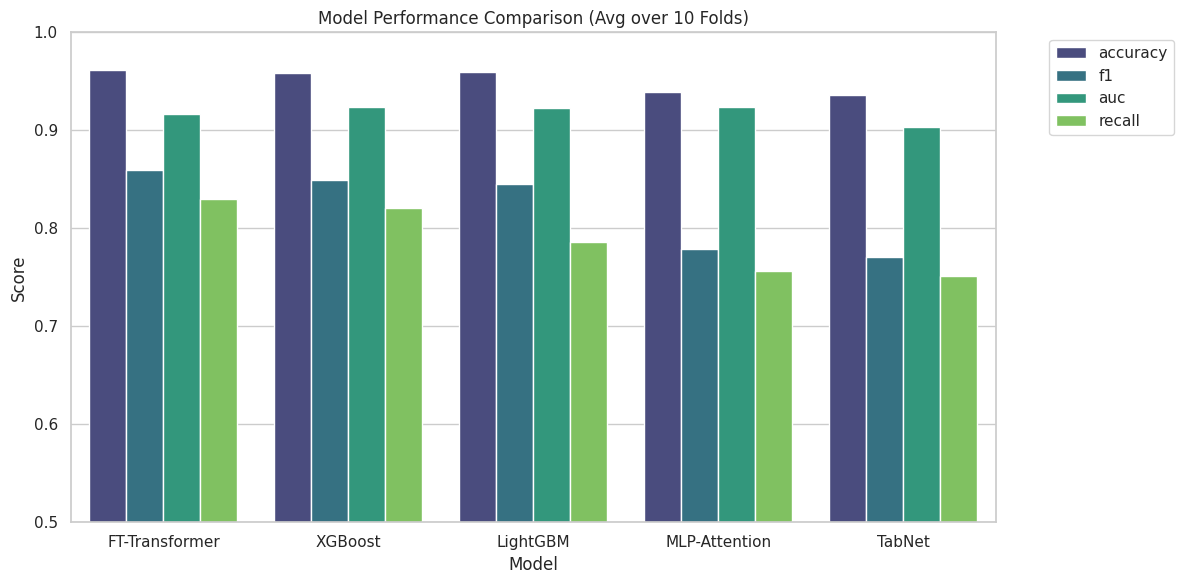

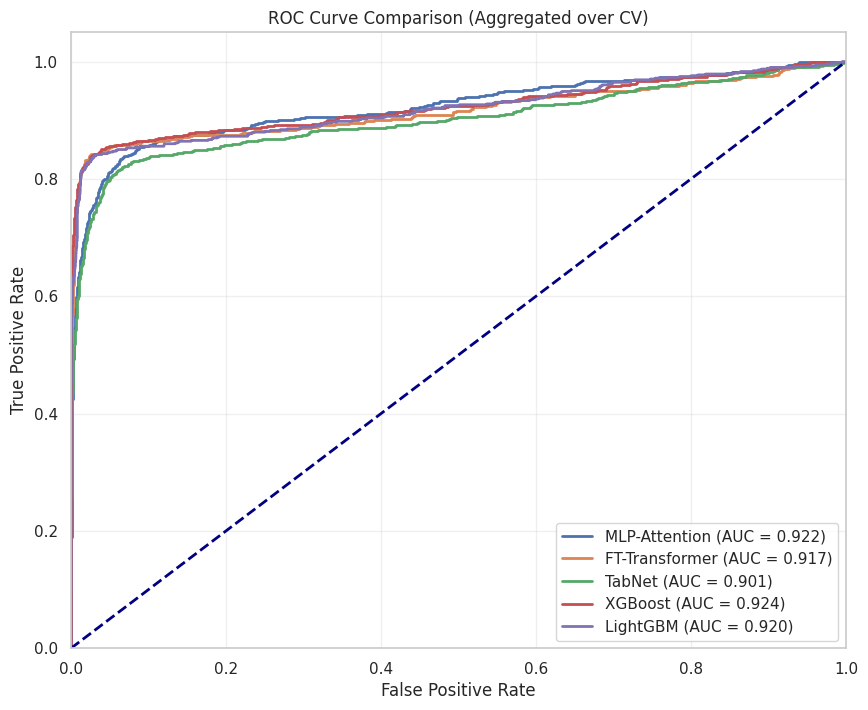

In [ ]:
if len(results_summary) > 0:
        print("\n\n" + "="*80)
        print("FINAL CHAMPIONSHIP LEADERBOARD")
        print("="*80)

        df_results = pd.DataFrame(results_summary).T
        if "f1" in df_results.columns:
            df_results = df_results.sort_values(by="f1", ascending=False)
        print(df_results)
        print("="*80)
        print(f"WINNER: {df_results.index[0]}")

        # --- PLOT 1: Performance Metrics Comparison ---
        plt.figure(figsize=(12, 6))
        # Melt dataframe for seaborn
        df_melted = df_results.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
        # Filter for key metrics to avoid clutter
        key_metrics = ['accuracy', 'f1', 'auc', 'recall']
        df_melted = df_melted[df_melted['Metric'].isin(key_metrics)]

        sns.barplot(data=df_melted, x='index', y='Score', hue='Metric', palette='viridis')
        plt.title('Model Performance Comparison (Avg over 10 Folds)')
        plt.xlabel('Model')
        plt.ylabel('Score')
        plt.ylim(0.5, 1.0) # Zoom in on the top half
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # --- PLOT 2: ROC Curves ---
        plt.figure(figsize=(10, 8))
        for name, (y_t, y_p) in roc_data.items():
            fpr, tpr, _ = roc_curve(y_t, y_p)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve Comparison (Aggregated over CV)')
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.show()

/tmp/ipython-input-1383154259.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


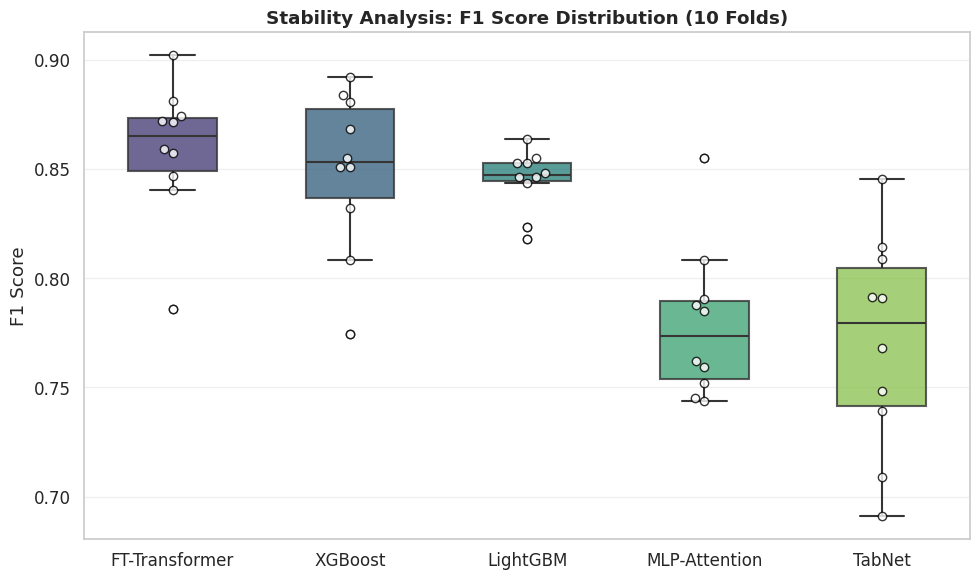

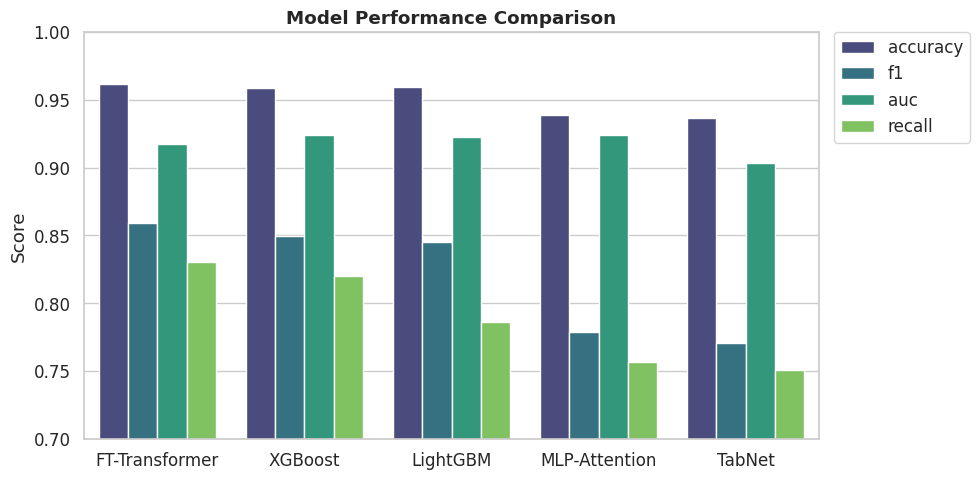

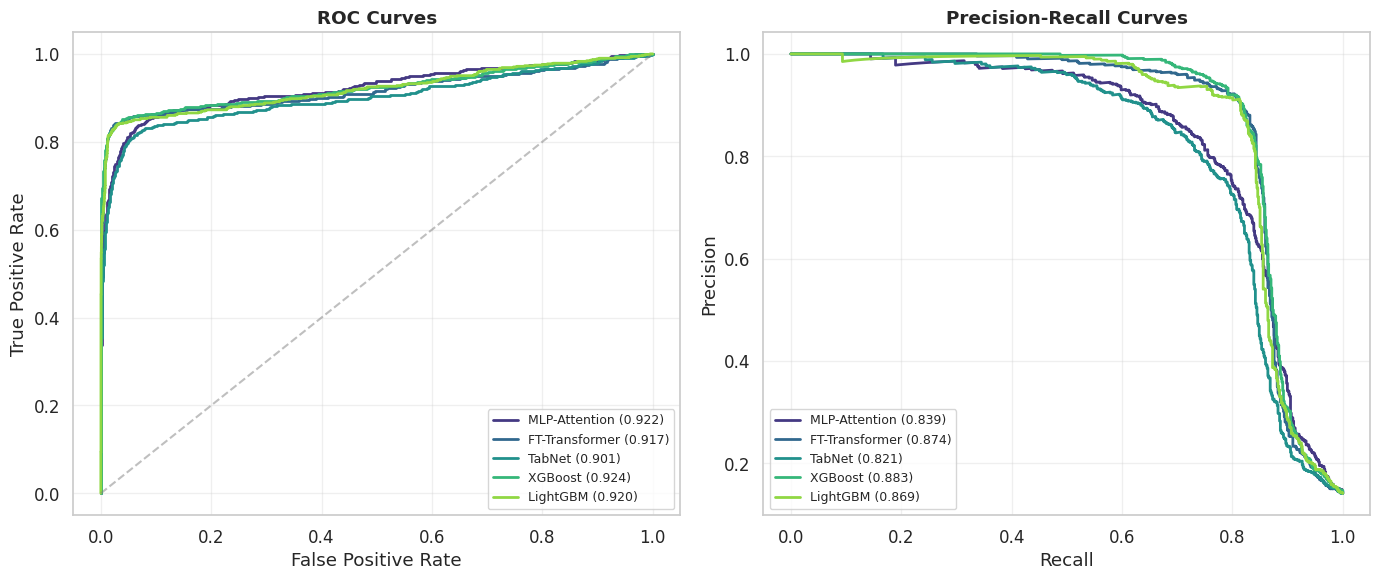

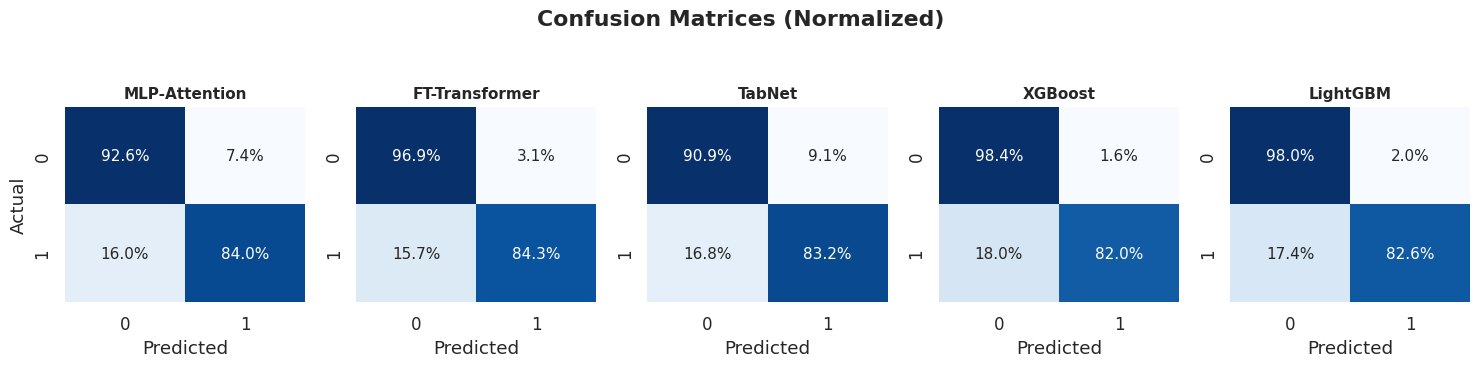

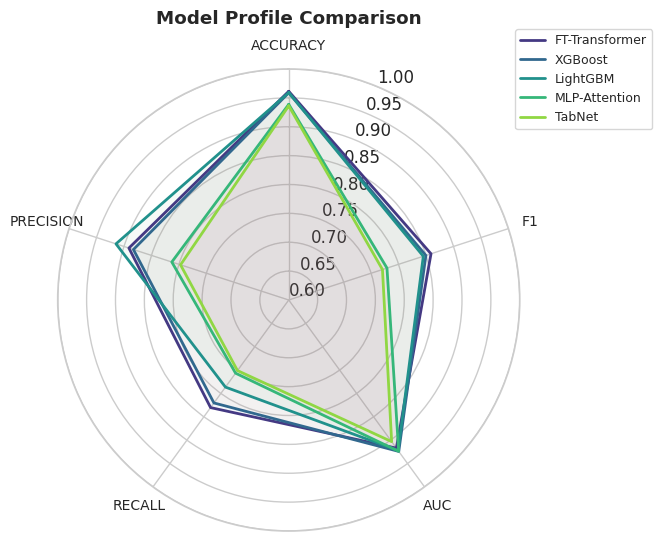

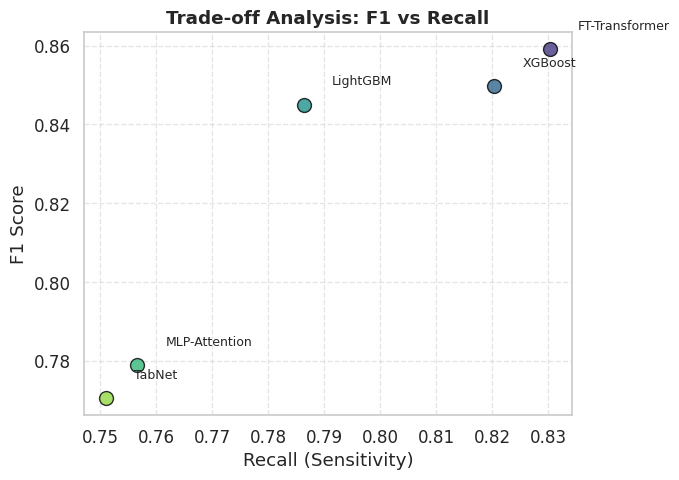

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from math import pi
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

# --- 1. SETUP STYLE FOR PAPER ---
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1) # Cleaner, smaller fonts
palette = sns.color_palette("viridis", n_colors=len(roc_data))

# --------------------------------------------
# 0. STABILITY ANALYSIS (BOX PLOT)
# --------------------------------------------
if 'raw_metrics_storage' in locals() and raw_metrics_storage:
    plt.figure(figsize=(10, 6))

    box_data = []
    for model_name, scores in raw_metrics_storage.items():
        for score in scores:
            box_data.append({'Model': model_name, 'F1 Score': score})

    df_box = pd.DataFrame(box_data)

    # CRITICAL FIX: Sort the box plot by the same order as the leaderboard
    # This ensures colors match between the Bar Plot and Box Plot
    order_by_f1 = df_results.index if 'df_results' in locals() else None

    # 1. The Box Plot
    sns.boxplot(
        data=df_box,
        x='Model',
        y='F1 Score',
        order=order_by_f1,
        palette='viridis',
        width=0.5,
        linewidth=1.5,
        boxprops=dict(alpha=0.8)
    )

    # 2. The Swarm Plot
    sns.swarmplot(
        data=df_box,
        x='Model',
        y='F1 Score',
        order=order_by_f1,
        color='white',
        edgecolor='black',
        linewidth=1,
        alpha=0.8,
        size=6
    )

    plt.title("Stability Analysis: F1 Score Distribution (10 Folds)", fontweight='bold')
    plt.ylabel("F1 Score")
    plt.xlabel("")
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Box Plot: 'raw_metrics_storage' not found.")

# --------------------------------------------
# 1. CLEAN METRIC BAR PLOT (COMPACT)
# --------------------------------------------
plt.figure(figsize=(10, 5)) # Much smaller, cleaner size

# Reshape data for Seaborn
df_melted = df_results[['accuracy', 'f1', 'auc', 'recall']].reset_index().melt(
    id_vars='index', var_name='Metric', value_name='Score'
)

ax = sns.barplot(
    data=df_melted,
    x='index',
    y='Score',
    hue='Metric',
    palette='viridis'
)

plt.title("Model Performance Comparison", fontweight='bold')
plt.xlabel("") # Remove 'Model' label (names are enough)
plt.ylabel("Score")
plt.ylim(0.7, 1.0) # Zoom in on the relevant range
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

# --------------------------------------------
# 2. ROC & PRECISION-RECALL (SIDE-BY-SIDE)
# --------------------------------------------
# Combining these into one figure saves space in a paper
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Left: ROC Curve ---
for i, (model_name, (y_true, y_prob)) in enumerate(roc_data.items()):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, lw=2, color=palette[i], label=f"{model_name} ({roc_auc:.3f})")

axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.5)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curves", fontweight="bold")
axes[0].legend(loc="lower right", fontsize=9)
axes[0].grid(alpha=0.3)

# --- Right: Precision-Recall ---
for i, (model_name, (y_true, y_prob)) in enumerate(roc_data.items()):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    axes[1].plot(recall, precision, lw=2, color=palette[i], label=f"{model_name} ({pr_auc:.3f})")

axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curves", fontweight="bold")
axes[1].legend(loc="lower left", fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --------------------------------------------
# 3. NORMALIZED CONFUSION MATRICES (GRID)
# --------------------------------------------
n_models = len(roc_data)
# Dynamic sizing: 3 inches wide per subplot
fig, axes = plt.subplots(1, n_models, figsize=(3 * n_models, 3.5))

if n_models == 1: axes = [axes]

for ax, (model_name, (y_true, y_prob)) in zip(axes, roc_data.items()):
    y_pred = (y_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    sns.heatmap(
        cm,
        annot=True,
        fmt=".1%", # Show as percentages (easier to read)
        cmap="Blues",
        cbar=False,
        ax=ax,
        annot_kws={"size": 11}
    )
    ax.set_title(model_name, fontsize=11, fontweight='bold')
    ax.set_xlabel("Predicted")
    if ax == axes[0]: ax.set_ylabel("Actual") # Only show Y label on first plot
    else: ax.set_ylabel("")

plt.suptitle("Confusion Matrices (Normalized)", y=1.05, fontweight="bold")
plt.tight_layout()
plt.show()

# --------------------------------------------
# 4. RADAR CHART (COMPACT)
# --------------------------------------------
metrics_for_radar = ['accuracy', 'f1', 'auc', 'recall', 'precision']
labels = [m.upper() for m in metrics_for_radar]
num_vars = len(labels)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i, model in enumerate(df_results.index):
    values = df_results.loc[model, metrics_for_radar].values.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model, color=palette[i])
    ax.fill(angles, values, alpha=0.05)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, size=10)
ax.set_ylim(0.6, 1.0) # Zoom in to show differences
plt.title("Model Profile Comparison", fontweight="bold", y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
plt.show()

# --------------------------------------------
# 5. F1 vs RECALL TRADEOFF
# --------------------------------------------
plt.figure(figsize=(7, 5))

for i, model in enumerate(df_results.index):
    x = df_results.loc[model, 'recall']
    y = df_results.loc[model, 'f1']

    plt.scatter(x, y, s=100, color=palette[i], edgecolors='black', label=model, alpha=0.8)

    # Smart labelling to avoid overlap
    plt.text(x + 0.005, y + 0.005, model, fontsize=9)

plt.xlabel("Recall (Sensitivity)")
plt.ylabel("F1 Score")
plt.title("Trade-off Analysis: F1 vs Recall", fontweight="bold")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

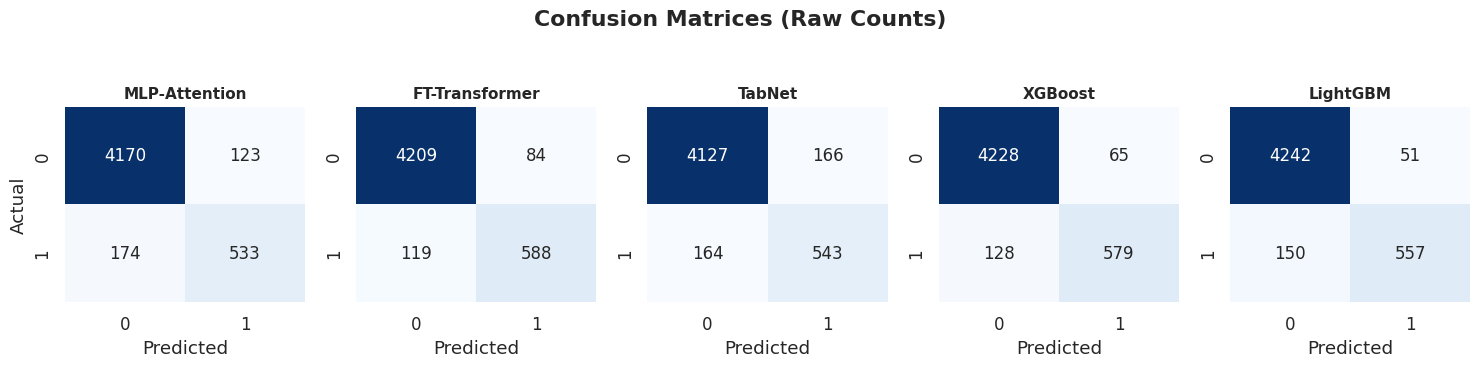

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --------------------------------------------
# 3. CONFUSION MATRICES (RAW COUNTS)
# --------------------------------------------
n_models = len(roc_data)
fig, axes = plt.subplots(1, n_models, figsize=(3 * n_models, 3.5))

if n_models == 1: axes = [axes]

for ax, (model_name, (y_true, y_prob)) in zip(axes, roc_data.items()):

    # Use the saved threshold if it exists, otherwise default to 0.5
    thresh = final_thresholds.get(model_name, 0.5) if 'final_thresholds' in locals() else 0.5

    y_pred = (y_prob >= thresh).astype(int)

    # Calculate raw counts (no normalization)
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",      # 'd' ensures raw integers are displayed
        cmap="Blues",
        cbar=False,
        ax=ax,
        annot_kws={"size": 12}
    )

    # --- UPDATED: Title now contains ONLY the model name ---
    ax.set_title(model_name, fontsize=11, fontweight='bold')

    ax.set_xlabel("Predicted")
    if ax == axes[0]: ax.set_ylabel("Actual")
    else: ax.set_ylabel("")

plt.suptitle("Confusion Matrices (Raw Counts)", y=1.05, fontweight="bold")
plt.tight_layout()
plt.show()

Generating SHAP explanations...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:21:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipython-input-3670731341.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_shap, feature_names=X_raw.columns, show=False)


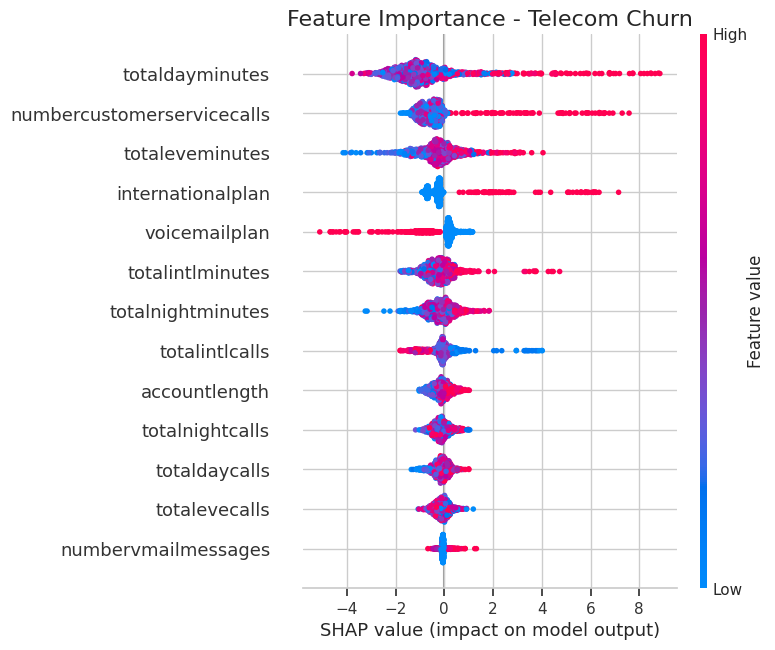

Graph saved as SHAP_Telecom_Summary.png


In [ ]:
# ==========================================
# SHAP Analysis (Telecom Churn)
# ==========================================
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print("Generating SHAP explanations...")

# 1. Prepare a specific Train/Test split for SHAP
# We use X_raw.columns to ensure the plot shows names like "International Plan" instead of "Feature 0"
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# 2. Train a dedicated XGBoost model for interpretation
# (Using default params is fine for importance visualization)
model_shap = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_shap.fit(X_train_shap, y_train_shap)

# 3. Calculate SHAP Values
explainer = shap.TreeExplainer(model_shap)
shap_values = explainer.shap_values(X_test_shap)

# 4. Generate & Save Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_shap, feature_names=X_raw.columns, show=False)
plt.title("Feature Importance - Telecom Churn", fontsize=16)
plt.tight_layout()
plt.savefig("SHAP_Telecom_Summary.png", dpi=300)
plt.show()

print("Graph saved as SHAP_Telecom_Summary.png")